# 0. Import_Library & check_version

In [1]:
import sys
import pandas as pd
import netCDF4 as nc
import numpy as np
import scipy
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import math
from datetime import datetime
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import folium
from folium import plugins

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Python version:", sys.version)
print("pandas version:", pd.__version__)
print("netCDF4 version:", nc.__version__)
print("numpy version:", np.__version__)
print("scipy version:", scipy.__version__)
print("seaborn version:", sns.__version__)
print("matplotlib version:", matplotlib.__version__)
print("lightgbm version:", lgb.__version__)
print("scikit-learn version", sklearn.__version__)
print("folium version:", folium.__version__)

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
pandas version: 2.0.3
netCDF4 version: 1.6.4
numpy version: 1.24.3
scipy version: 1.11.1
seaborn version: 0.12.2
matplotlib version: 3.7.2
lightgbm version: 4.1.0
scikit-learn version 1.3.0
folium version: 0.14.0


# 1. Preprocessing(1)_2005~2006

## 1.1. original_data

In [3]:
# 홈페이지 제공 파일 읽기
dataset = nc.Dataset("data/NOAA_drifter_2005.nc", "r")

# 데이터를 pandas Data Frame으로 변환
lon = pd.DataFrame(dataset["lons"][:])
lat = pd.DataFrame(dataset["lats"][:])
time = pd.DataFrame(dataset["times"][:])

lon = lon.fillna(0)
lat = lat.fillna(0)

In [4]:
# .nc확장자 파일을 분석에 용이하게 csv파일로 변환
drifter = []
t = []
longitude = []
latitude =[]

for i in range(31):
    for j in range(1412):
        if lon.iloc[i][j] == 0:
            break
        else:
            drifter.append(i)
            t.append(time.iloc[i][j])
            longitude.append(lon.iloc[i][j])
            latitude.append(lat.iloc[i][j])
            
data = {
    "drifter" : drifter,
    "time" : t,
    "longitude" : longitude,
    "latitude" : latitude
}
columns = ["drifter","time","longitude","latitude"]
total = pd.DataFrame(data, columns = columns)
total.to_csv("data/total.csv",index = False)
total

,drifter,time,longitude,latitude
0,0,51.25,129.311005,34.950001
1,0,51.50,129.401993,35.020000
2,0,51.75,129.514008,35.061001
3,0,52.00,129.524002,35.032001
4,0,52.25,129.626007,35.083000
...,...,...,...,...
15840,30,638.00,147.348999,44.167999
15841,30,638.25,147.307007,44.138000
15842,30,638.50,147.250000,44.146999
15843,30,638.75,147.322998,44.201000


## 1.2. water_velocity

In [5]:
# https://data.marine.copernicus.eu/product/MULTIOBS_GLO_PHY_REP_015_004/services
# 홈페이지에서 2005년 1월 1일 ~ 2006년 12월 31일까지의 표층 해류 데이터 수집
dataset = nc.Dataset("data/water_velocity.nc", "r")

lat = pd.DataFrame(dataset["latitude"][:])
lon = pd.DataFrame(dataset["longitude"][:])

In [6]:
# 3차원으로 되어 있는 데이터를 시간과 위도 경도에 맞게 수정해서 
# Data Frame으로 바꾸고 csv 파일로 저장

t = [i for i in range(int(0 * 100), int((729.75 + 0.25) * 100), int(0.25 * 100)) for _ in range(8740)]
t = [x / 100 for x in t]

lati = []
for i in range(len(lat)):
    cnt = [lat.iloc[i][0]] * 92
    lati += cnt
lati *= 2920

long = []
for i in range(len(lon)):
    long.append(lon.iloc[i][0])
long *= 95
long *= 2920

u_lst = []
for i in range(2920):
    x = pd.DataFrame(dataset["uo"][i * 2][0][:])
    new_x = x.values.flatten().tolist()
    u_lst.append(new_x)

v_lst = []
for i in range(2920):
    x = pd.DataFrame(dataset["vo"][i * 2][0][:])
    new_x = x.values.flatten().tolist()
    v_lst.append(new_x)
    
def flatten(lst):
    flattened_lst = []
    for sublist in lst:
        for item in sublist:
            flattened_lst.append(item)
    return flattened_lst

u_lst = flatten(u_lst)
v_lst = flatten(v_lst)

data = {
    "time" : t,
    "longitude" : long,
    "latitude" : lati,
    "u" : u_lst,
    "v" : v_lst
}
columns = ["time","longitude","latitude","u","v"]
total = pd.DataFrame(data, columns = columns)
total.to_csv("data/water_velocity.csv", index = False)
total

,time,longitude,latitude,u,v
0,0.00,123.875,30.125,0.086603,-0.309205
1,0.00,124.125,30.125,0.067756,-0.295678
2,0.00,124.375,30.125,0.081384,-0.253029
3,0.00,124.625,30.125,0.104257,-0.347986
4,0.00,124.875,30.125,0.097815,-0.409650
...,...,...,...,...,...
25520795,729.75,145.625,53.625,0.014556,-0.133729
25520796,729.75,145.875,53.625,0.006857,-0.136531
25520797,729.75,146.125,53.625,-0.000076,-0.133501
25520798,729.75,146.375,53.625,-0.004371,-0.127829


## 1.3. wind_velocity

In [7]:
# ERA5 hourly data on single levels from 1940 to present (copernicus.eu)
# 홈페이지에서 2005년 1월 1일 ~ 2006년 12월 31일까지의 표층 바람 데이터 수집
dataset = nc.Dataset("data/wind_velocity.nc", "r")

lon = pd.DataFrame(dataset["longitude"][:])
lat = pd.DataFrame(dataset["latitude"][:])

In [8]:
# water velocity와 같은 과정 시행
t = [i for i in range(int(0 * 100), int((729.75 + 0.25) * 100), int(0.25 * 100)) for _ in range(8648)]
t = [x / 100 for x in t]

lati = []
for i in range(len(lat)):
    cnt = [lat.iloc[i][0]] * 92
    lati += cnt
lati *= 2920

long = []
for i in range(len(lon)):
    long.append(lon.iloc[i][0])
long *= 94
long *= 2920

u_lst = []
for i in range(2920):
    x = pd.DataFrame(dataset["u10"][i][:])
    new_x = x.values.flatten().tolist()
    u_lst.append(new_x)

v_lst = []
for i in range(2920):
    x = pd.DataFrame(dataset["v10"][i][:])
    new_x = x.values.flatten().tolist()
    v_lst.append(new_x)

def flatten(lst):
    flattened_lst = []
    for sublist in lst:
        for item in sublist:
            flattened_lst.append(item)
    return flattened_lst

u_lst = flatten(u_lst)
v_lst = flatten(v_lst)

data = {
    "time" : t,
    "longitude" : long,
    "latitude" : lati,
    "u" : u_lst,
    "v" : v_lst
}
columns = ["time","longitude","latitude","u","v"]
total = pd.DataFrame(data, columns = columns)
total.to_csv("data/wind_velocity.csv", index = False)
total

,time,longitude,latitude,u,v
0,0.00,123.870003,53.419998,2.402039,-0.358427
1,0.00,124.120003,53.419998,1.691783,-0.733214
2,0.00,124.370003,53.419998,1.524293,-0.872892
3,0.00,124.620003,53.419998,1.954870,-0.847732
4,0.00,124.870003,53.419998,1.906677,-0.957045
...,...,...,...,...,...
25252155,729.75,145.619995,30.170000,-2.655869,-6.472146
25252156,729.75,145.869995,30.170000,-2.273484,-6.987479
25252157,729.75,146.119995,30.170000,-1.800243,-7.395234
25252158,729.75,146.369995,30.170000,-1.362555,-7.745729


## 1.4 add_water_wind_velocity_<br>in_original_data_with_weighted_average

In [9]:
main = pd.read_csv("data/total.csv")
water = pd.read_csv("data/water_velocity.csv")
wind = pd.read_csv("data/wind_velocity.csv")

* u : +는 동쪽, -는 서쪽<br>
* v : +는 북쪽, -는 남쪽

In [10]:
water = water.fillna(0)
wind = wind.fillna(0)

In [11]:
# drfiter의 움직임을 위도, 경도의 변화량으로 나타내어서 추후에 회귀에 사용할 예정
main["water_u"] = 0
main["water_v"] = 0
main["wind_u"] = 0
main["wind_v"] = 0
main['d_long'] = main['longitude'].diff().fillna(0)
main['d_lati'] = main['latitude'].diff().fillna(0)

main = main.groupby('drifter').apply(lambda group: group.iloc[1:]).reset_index(drop=True)

In [12]:
# 위도, 경도를 이용하여 그리드 생성
grid = water[['longitude', 'latitude']].drop_duplicates().values

# 근접한 그리드 찾는 함수
kdtree = cKDTree(grid)

# 그리드 내에서 각각의 꼭지점 찾아내는 함수
def find_closest_vertices(row):
    point = np.array([row['longitude'], row['latitude']])
    _, indices = kdtree.query(point, k=4)
    return indices

# 찾아낸 꼭지점들을 Data Frame에 할당
main['closest_vertices'] = main.apply(find_closest_vertices, axis=1)

In [13]:
# 찾아낸 꼭지점들을 시간에 맞게 다시 찾아내고
# 가중치 평균을 활용하여 그 지점에서의 u, v를 추정(water velocity)
u = []
v = []
for i in range(len(main)):
    x = water.loc[water["time"] == main.iloc[i][1]]
    w_u = []
    w_v = []
    w_d = []
    for j in main.iloc[i][-1]:
        d = ((main.iloc[i][2] - x.iloc[j][1])**2 + (main.iloc[i][3] - x.iloc[j][2])**2) ** 0.5
        w_u.append(x.iloc[j][-2])
        w_v.append(x.iloc[j][-1])
        w_d.append(d)

    # weithged average
    total_weight = sum(w_d)
    weighted_u = sum(w_u[i] * w_d[i] for i in range(len(w_d))) / total_weight
    weighted_v = sum(w_v[i] * w_d[i] for i in range(len(w_d))) / total_weight

    u.append(weighted_u)
    v.append(weighted_v)

main["water_u"] = u
main["water_v"] = v

In [14]:
# 위도, 경도를 이용하여 그리드 생성
grid2 = wind[['longitude', 'latitude']].drop_duplicates().values

# 근접한 그리드 찾는 함수
kdtree = cKDTree(grid2)

# 그리드 내에서 각각의 꼭지점 찾아내는 함수
def find_closest_vertices(row):
    point = np.array([row['longitude'], row['latitude']])
    _, indices = kdtree.query(point, k=4)
    return indices

# 찾아낸 꼭지점들을 Data Frame에 할당
main['closest_vertices2'] = main.apply(find_closest_vertices, axis=1)

In [15]:
# 같은 과정을 거치며 wind velocity 추정
u = []
v = []
for i in range(len(main)):
    x = wind.loc[wind["time"] == main.iloc[i][1]]
    w_u = []
    w_v = []
    w_d = []
    for j in main.iloc[i][-1]:
        d = ((main.iloc[i][2] - x.iloc[j][1])**2 + (main.iloc[i][3] - x.iloc[j][2])**2) ** 0.5
        w_u.append(x.iloc[j][-2])
        w_v.append(x.iloc[j][-1])
        w_d.append(d)

    # weighted_average
    total_weight = sum(w_d)
    weighted_u = sum(w_u[i] * w_d[i] for i in range(len(w_d))) / total_weight
    weighted_v = sum(w_v[i] * w_d[i] for i in range(len(w_d))) / total_weight

    u.append(weighted_u)
    v.append(weighted_v)
main["wind_u"] = u
main["wind_v"] = v
main.to_csv("data/total_add_velocity_weighted_average.csv", index = False)
main

,drifter,time,longitude,latitude,water_u,water_v,wind_u,wind_v,d_long,d_lati,closest_vertices,closest_vertices2
0,0,51.50,129.401993,35.020000,0.089673,0.041876,4.087482,-1.265760,0.090988,0.070000,"[1862, 1770, 1863, 1771]","[6830, 6738, 6831, 6739]"
1,0,51.75,129.514008,35.061001,0.095552,0.053962,3.988419,-1.597433,0.112015,0.041000,"[1863, 1862, 1771, 1770]","[6739, 6831, 6738, 6830]"
2,0,52.00,129.524002,35.032001,0.113870,0.135307,1.290056,0.333414,0.009995,-0.028999,"[1863, 1862, 1771, 1770]","[6831, 6739, 6830, 6738]"
3,0,52.25,129.626007,35.083000,0.259294,0.156671,5.640256,8.854036,0.102005,0.050999,"[1863, 1771, 1864, 1862]","[6739, 6831, 6740, 6738]"
4,0,52.50,129.712997,35.058998,0.368874,0.064946,13.505250,7.603525,0.086990,-0.024002,"[1863, 1864, 1771, 1772]","[6739, 6831, 6740, 6832]"
...,...,...,...,...,...,...,...,...,...,...,...,...
15809,30,638.00,147.348999,44.167999,0.076116,-0.035941,3.090491,1.099326,0.029999,-0.000999,"[5243, 5335, 5151, 5427]","[3495, 3587, 3403, 3679]"
15810,30,638.25,147.307007,44.138000,0.075121,-0.036927,1.551420,2.108921,-0.041992,-0.029999,"[5243, 5335, 5151, 5427]","[3495, 3587, 3403, 3679]"
15811,30,638.50,147.250000,44.146999,0.081807,-0.019462,1.289979,4.271356,-0.057007,0.008999,"[5243, 5335, 5151, 5427]","[3495, 3587, 3403, 3679]"
15812,30,638.75,147.322998,44.201000,0.081604,-0.005729,0.537444,4.900105,0.072998,0.054001,"[5243, 5335, 5151, 5427]","[3495, 3403, 3587, 3311]"


## 1.5 data_compare

In [16]:
water = pd.read_csv("data/water_velocity.csv")
wind = pd.read_csv("data/wind_velocity.csv")
weighted_average = pd.read_csv("data/total_add_velocity_weighted_average.csv")

In [17]:
water.describe()

,time,longitude,latitude,u,v
count,2.552080e+07,2.552080e+07,2.552080e+07,1.340436e+07,1.340436e+07
mean,3.648750e+02,1.352500e+02,4.187500e+01,7.979197e-02,4.069712e-04
std,2.107328e+02,6.639136e+00,6.855655e+00,2.709554e-01,2.368187e-01
min,0.000000e+00,1.238750e+02,3.012500e+01,-1.936782e+00,-2.009524e+00
25%,1.824375e+02,1.295625e+02,3.587500e+01,-4.881348e-02,-1.128190e-01
50%,3.648750e+02,1.352500e+02,4.187500e+01,3.915852e-02,-2.121923e-03
75%,5.473125e+02,1.409375e+02,4.787500e+01,1.477528e-01,1.012413e-01
max,7.297500e+02,1.466250e+02,5.362500e+01,2.586444e+00,2.339630e+00


In [18]:
wind.describe()

,time,longitude,latitude,u,v
count,2.525216e+07,2.525216e+07,2.525216e+07,2.525216e+07,2.525216e+07
mean,3.648750e+02,1.352450e+02,4.179500e+01,1.116360e+00,-4.371712e-01
std,2.107328e+02,6.639136e+00,6.783482e+00,4.192018e+00,4.316797e+00
min,0.000000e+00,1.238700e+02,3.017000e+01,-2.653438e+01,-2.753485e+01
25%,1.824375e+02,1.295575e+02,3.592000e+01,-1.237727e+00,-2.694775e+00
50%,3.648750e+02,1.352450e+02,4.179500e+01,9.515053e-01,-1.927219e-01
75%,5.473125e+02,1.409325e+02,4.767000e+01,3.276626e+00,2.040386e+00
max,7.297500e+02,1.466200e+02,5.342000e+01,2.524005e+01,2.931918e+01


In [19]:
weighted_average.describe()

,drifter,time,longitude,latitude,water_u,water_v,wind_u,wind_v,d_long,d_lati
count,15814.000000,15814.000000,15814.000000,15814.000000,15814.000000,15814.000000,15814.000000,15814.000000,15814.000000,15814.000000
mean,15.866384,341.630644,134.255299,38.418786,0.067218,0.010328,1.660523,-0.880041,0.014679,0.006684
std,8.613671,140.691731,3.622366,2.460060,0.127383,0.147013,4.909348,5.117672,0.053495,0.043642
min,0.000000,51.500000,125.299004,33.140999,-0.575163,-0.679846,-14.140655,-20.096183,-0.230011,-0.247002
25%,9.000000,240.250000,131.248001,36.632000,-0.013054,-0.072655,-1.926776,-4.517272,-0.016998,-0.016998
50%,16.000000,348.000000,133.824501,37.919998,0.059511,0.010874,1.594692,-0.827580,0.010010,0.006001
75%,23.000000,436.250000,136.547752,39.633999,0.141066,0.099123,5.092165,2.927425,0.043991,0.031002
max,30.000000,666.000000,148.697998,46.507000,1.135976,0.677020,17.747073,19.721193,0.475006,0.247002


* Real

|u,v|min|max|avg|std|u,v|min|max|avg|std|
|------|---|---|---|---|------|---|---|---|---|
|water_u|-1.936782|2.586444|0.07979197|0.2709554|wind_u|-26.53438|25.24005|1.116360|4.192018|
|water_v|-2.009524|2.339630|0.00040697|0.2368187|wind_v|-27.53485|29.31918|-0.4371712|4.316797|

* weighted_average

|u,v|min|max|avg|std|u,v|min|max|avg|std|
|------|---|---|---|---|------|---|---|---|---|
|water_u|-0.575163|1.135976|0.067222|0.127380|wind_u|-14.140655|17.747073|1.660523|4.909348|
|water_v|-0.679846|0.677020|0.010330|0.147012|wind_v|-20.096183|19.721193|-0.880041|5.117672|

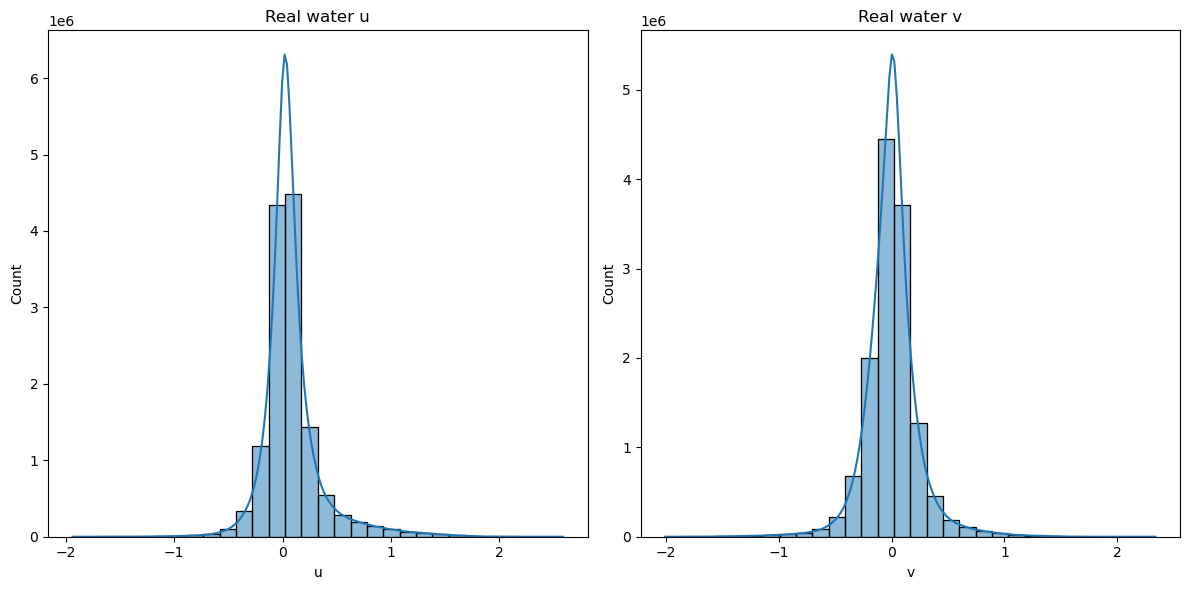

In [20]:
df = water

# 'u'와 'v' 열의 분포 시각화
plt.figure(figsize=(12, 6))  # 그래프의 크기 설정

# 'u' 열의 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(df['u'], bins=30, kde=True)
plt.title('Real water u')
plt.xlabel('u')

# 'v' 열의 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(df['v'], bins=30, kde=True)
plt.title('Real water v')
plt.xlabel('v')

plt.tight_layout()
plt.show()

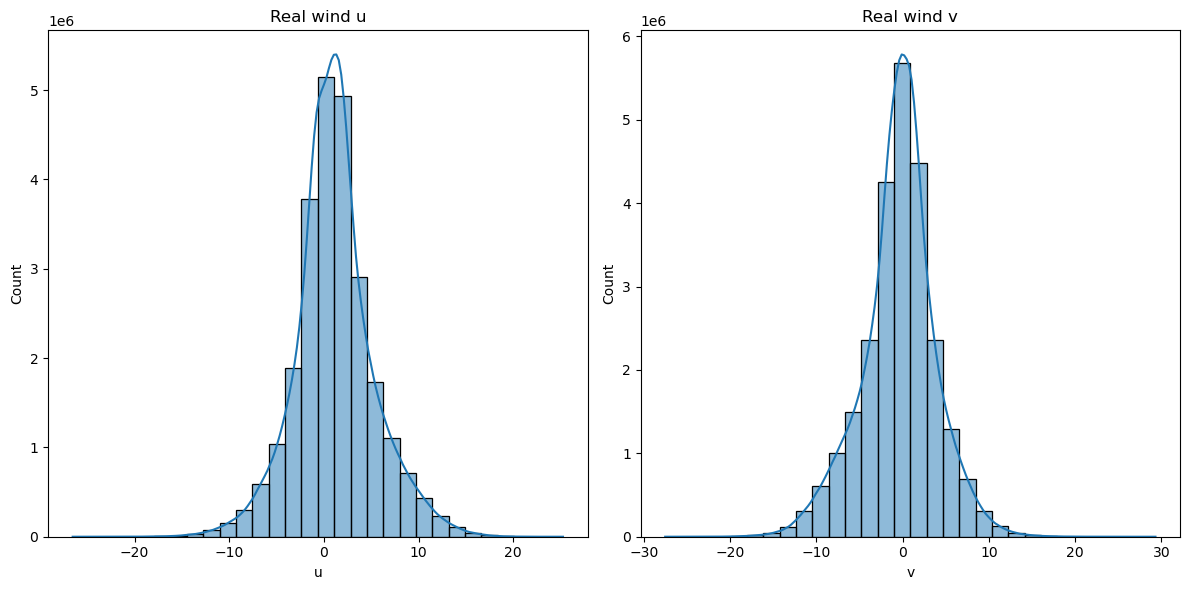

In [21]:
df = wind

# 'u'와 'v' 열의 분포 시각화
plt.figure(figsize=(12, 6))  # 그래프의 크기 설정

# 'u' 열의 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(df['u'], bins=30, kde=True)
plt.title('Real wind u')
plt.xlabel('u')

# 'v' 열의 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(df['v'], bins=30, kde=True)
plt.title('Real wind v')
plt.xlabel('v')

plt.tight_layout()
plt.show()

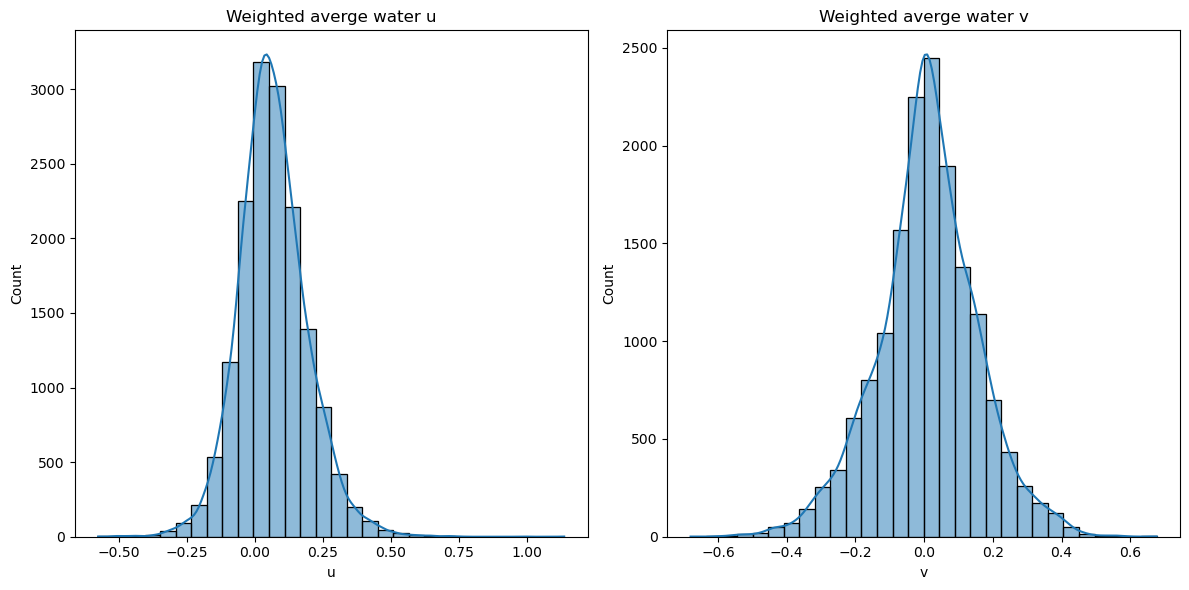

In [22]:
df = weighted_average

# 'u'와 'v' 열의 분포 시각화
plt.figure(figsize=(12, 6))  # 그래프의 크기 설정

# 'u' 열의 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(df['water_u'], bins=30, kde=True)
plt.title('Weighted averge water u')
plt.xlabel('u')

# 'v' 열의 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(df['water_v'], bins=30, kde=True)
plt.title('Weighted averge water v')
plt.xlabel('v')

plt.tight_layout()
plt.show()

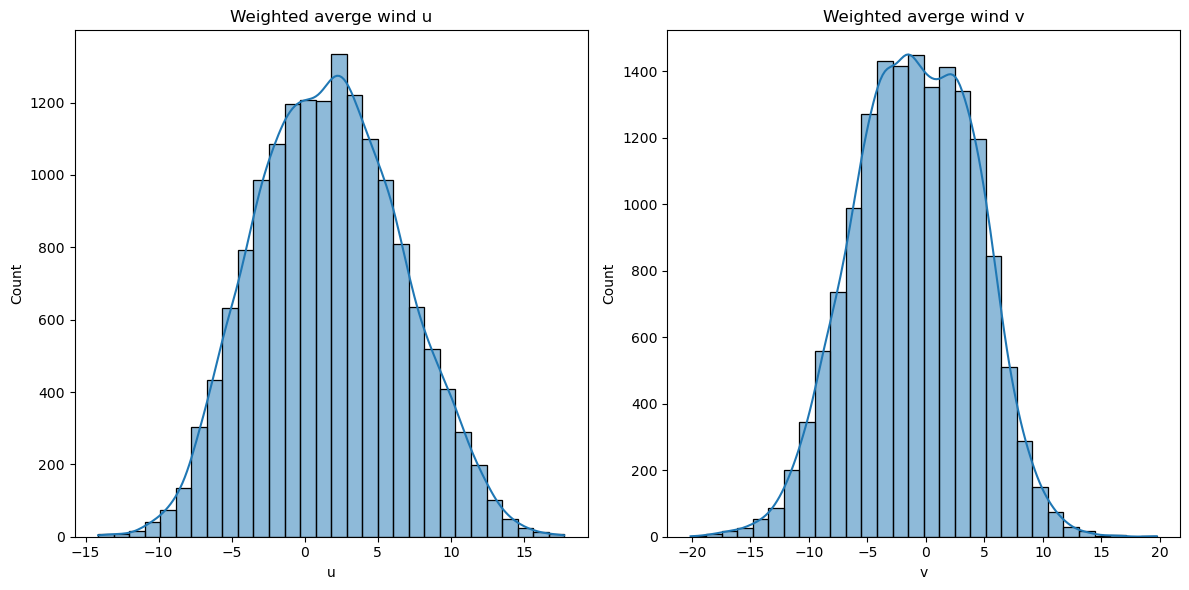

In [23]:
df = weighted_average

# 'u'와 'v' 열의 분포 시각화
plt.figure(figsize=(12, 6))  # 그래프의 크기 설정

# 'u' 열의 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(df['wind_u'], bins=30, kde=True)
plt.title('Weighted averge wind u')
plt.xlabel('u')

# 'v' 열의 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(df['wind_v'], bins=30, kde=True)
plt.title('Weighted averge wind v')
plt.xlabel('v')

plt.tight_layout()
plt.show()

# 2. Proeprocessing(2)_2016~2017

## 2.1 water_velocity

In [24]:
dataset = nc.Dataset("data/water_velocity2016.nc", "r")

lat = pd.DataFrame(dataset["latitude"][:])
lon = pd.DataFrame(dataset["longitude"][:])

In [25]:
t = [i for i in range(int(0 * 100), int((730.75 + 0.25) * 100), int(0.25 * 100)) for _ in range(8740)]
t = [x / 100 for x in t]

lati = []
for i in range(len(lat)):
    cnt = [lat.iloc[i][0]] * 92
    lati += cnt
lati *= 2924

long = []
for i in range(len(lon)):
    long.append(lon.iloc[i][0])
long *= 95
long *= 2924

u_lst = []
for i in range(2924):
    x = pd.DataFrame(dataset["uo"][i * 2][0][:])
    new_x = x.values.flatten().tolist()
    u_lst.append(new_x)

v_lst = []
for i in range(2924):
    x = pd.DataFrame(dataset["vo"][i * 2][0][:])
    new_x = x.values.flatten().tolist()
    v_lst.append(new_x)
    
def flatten(lst):
    flattened_lst = []
    for sublist in lst:
        for item in sublist:
            flattened_lst.append(item)
    return flattened_lst

u_lst = flatten(u_lst)
v_lst = flatten(v_lst)

data = {
    "time" : t,
    "longitude" : long,
    "latitude" : lati,
    "u" : u_lst,
    "v" : v_lst
}
columns = ["time","longitude","latitude","u","v"]
total = pd.DataFrame(data, columns = columns)
total.to_csv("data/water_velocity2016.csv", index = False)
total

,time,longitude,latitude,u,v
0,0.00,123.875,30.125,-0.015589,-0.095239
1,0.00,124.125,30.125,-0.009355,-0.076038
2,0.00,124.375,30.125,0.008931,-0.017690
3,0.00,124.625,30.125,0.028254,-0.028880
4,0.00,124.875,30.125,0.008088,0.030922
...,...,...,...,...,...
25555755,730.75,145.625,53.625,-0.017071,-0.066713
25555756,730.75,145.875,53.625,-0.038780,-0.063514
25555757,730.75,146.125,53.625,-0.059290,-0.043422
25555758,730.75,146.375,53.625,-0.065427,-0.020789


## 2.2 wind_velocity

In [26]:
dataset = nc.Dataset("data/wind_velocity2016.nc", "r")

lon = pd.DataFrame(dataset["longitude"][:])
lat = pd.DataFrame(dataset["latitude"][:])

In [27]:
t = [i for i in range(int(0 * 100), int((730.75 + 0.25) * 100), int(0.25 * 100)) for _ in range(8648)]
t = [x / 100 for x in t]

lati = []
for i in range(len(lat)):
    cnt = [lat.iloc[i][0]] * 92
    lati += cnt
lati *= 2924

long = []
for i in range(len(lon)):
    long.append(lon.iloc[i][0])
long *= 94
long *= 2924

u_lst = []
for i in range(2924):
    x = pd.DataFrame(dataset["u10"][i][:])
    new_x = x.values.flatten().tolist()
    u_lst.append(new_x)

v_lst = []
for i in range(2924):
    x = pd.DataFrame(dataset["v10"][i][:])
    new_x = x.values.flatten().tolist()
    v_lst.append(new_x)

def flatten(lst):
    flattened_lst = []
    for sublist in lst:
        for item in sublist:
            flattened_lst.append(item)
    return flattened_lst

u_lst = flatten(u_lst)
v_lst = flatten(v_lst)

data = {
    "time" : t,
    "longitude" : long,
    "latitude" : lati,
    "u" : u_lst,
    "v" : v_lst
}
columns = ["time","longitude","latitude","u","v"]
total = pd.DataFrame(data, columns = columns)
total.to_csv("data/wind_velocity2016.csv", index = False)
total

,time,longitude,latitude,u,v
0,0.00,123.870003,53.419998,0.971710,-0.804258
1,0.00,124.120003,53.419998,0.744317,-0.908734
2,0.00,124.370003,53.419998,0.549026,-1.036213
3,0.00,124.620003,53.419998,0.401890,-0.998832
4,0.00,124.870003,53.419998,0.019335,-1.072636
...,...,...,...,...,...
25286747,730.75,145.619995,30.170000,1.097445,8.145185
25286748,730.75,145.869995,30.170000,0.249403,7.878725
25286749,730.75,146.119995,30.170000,-0.138503,7.554754
25286750,730.75,146.369995,30.170000,0.027360,7.066882


# 3. Predict_with_LGBMRegressor

In [28]:
data = pd.read_csv("data/total_add_velocity_weighted_average.csv")
water = pd.read_csv("data/water_velocity2016.csv")
wind = pd.read_csv("data/wind_velocity2016.csv")
# 홈페이지 내에서 구하고자 하는 시간대와 위치 정보로 만든 csv 파일
target = pd.read_csv("data/target.csv")

## 3.1 Make_predict_model

In [29]:
reg = data.copy()
reg = reg.iloc[:,4:10]

In [30]:
X_train, X_test, y_train_long, y_test_long = train_test_split(
    reg[['water_u', 'wind_u', 'wind_v']], reg['d_long'], test_size=0.2, random_state=42)
model_d_long = lgb.LGBMRegressor()
model_d_long.fit(X_train, y_train_long)

predictions_d_long = model_d_long.predict(X_test)
rmse_d_long = math.sqrt(mean_squared_error(y_test_long, predictions_d_long))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 12651, number of used features: 3
[LightGBM] [Info] Start training from score 0.015105


In [31]:
X_train, X_test, y_train_lati, y_test_lati = train_test_split(
    reg[['water_v', 'wind_u', 'wind_v']], reg['d_lati'], test_size=0.2, random_state=42)
model_d_lati = lgb.LGBMRegressor()
model_d_lati.fit(X_train, y_train_lati)

predictions_d_lati = model_d_lati.predict(X_test)
rmse_d_lati = math.sqrt(mean_squared_error(y_test_lati, predictions_d_lati))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 12651, number of used features: 3
[LightGBM] [Info] Start training from score 0.006790


In [32]:
print(f'RMSE for d_long: {rmse_d_long}')
print(f'RMSE for d_lati: {rmse_d_lati}')

RMSE for d_long: 0.04394599443791096
RMSE for d_lati: 0.034751875322104796


## 3.2 Preprocessing_target_data

In [33]:
drifter = [1,2,3,4,5,6,7]
t = []
lon = []
lat = []
for i in range(len(target)):
    start_date = datetime(2016, 1, 1)
    y = int(target.iloc[i][0])
    m = int(target.iloc[i][1])
    d = int(target.iloc[i][2])
    target_date = datetime(y, m, d)
    
    h = ((target.iloc[i][3] // 6) + 1) * 0.25
    x = (target_date - start_date).days
    x += h
    x -=1
    t.append(x)
    
    lon_deg = target.iloc[i][5]
    lon_min = target.iloc[i][6]
    
    lat_deg = target.iloc[i][7]
    lat_min = target.iloc[i][8]
    
    _lon = lon_deg + (lon_min / 60)
    _lat = lat_deg + (lat_min / 60)
    
    lon.append(_lon)
    lat.append(_lat)    
    
target["drifter"] = drifter    
target["time"] = t
target["longitude"] = lon
target["latitude"] = lat
target

,year,month,day,hour,minute,longitude_degree,longitude_minute,latitude_degree,latitude_minute,drifter,time,longitude,latitude
0,2016,3,13,11,49,127,4.310,32,30.442,1,71.50,127.071833,32.507367
1,2016,3,15,20,15,126,36.949,33,45.559,2,74.00,126.615817,33.759317
2,2016,3,19,12,1,129,16.916,34,56.978,3,77.75,129.281933,34.949633
3,2016,3,19,12,38,129,12.744,34,59.200,4,77.75,129.212400,34.986667
4,2016,7,15,15,40,127,4.468,32,30.976,5,195.75,127.074467,32.516267
5,2016,7,18,12,48,129,17.834,34,55.305,6,198.75,129.297233,34.921750
6,2016,7,20,1,49,129,23.897,37,33.155,7,200.25,129.398283,37.552583


In [34]:
main = target.iloc[:,9:]
main

,drifter,time,longitude,latitude
0,1,71.50,127.071833,32.507367
1,2,74.00,126.615817,33.759317
2,3,77.75,129.281933,34.949633
3,4,77.75,129.212400,34.986667
4,5,195.75,127.074467,32.516267
5,6,198.75,129.297233,34.921750
6,7,200.25,129.398283,37.552583


In [35]:
water = water.fillna(0)
wind = wind.fillna(0)

main["water_u"] = 0
main["water_v"] = 0
main["wind_u"] = 0
main["wind_v"] = 0
main['d_long'] = 0
main['d_lati'] = 0

In [36]:
# 앞서 했던 방법과 같은 방법을 사용하여 u,v 추정
grid = water[['longitude', 'latitude']].drop_duplicates().values

kdtree = cKDTree(grid)

def find_closest_vertices(row):
    point = np.array([row['longitude'], row['latitude']])
    _, indices = kdtree.query(point, k=4)
    return indices

main['closest_vertices'] = main.apply(find_closest_vertices, axis=1)

u = []
v = []
for i in range(len(main)):
    x = water.loc[water["time"] == main.iloc[i][1]]
    w_u = []
    w_v = []
    w_d = []
    for j in main.iloc[i][-1]:
        d = ((main.iloc[i][2] - x.iloc[j][1])**2 + (main.iloc[i][3] - x.iloc[j][2])**2) ** 0.5
        w_u.append(x.iloc[j][-2])
        w_v.append(x.iloc[j][-1])
        w_d.append(d)

    # weithged average
    total_weight = sum(w_d)
    weighted_u = sum(w_u[i] * w_d[i] for i in range(len(w_d))) / total_weight
    weighted_v = sum(w_v[i] * w_d[i] for i in range(len(w_d))) / total_weight

    u.append(weighted_u)
    v.append(weighted_v)

main["water_u"] = u
main["water_v"] = v

In [37]:
grid2 = wind[['longitude', 'latitude']].drop_duplicates().values

kdtree = cKDTree(grid2)

def find_closest_vertices(row):
    point = np.array([row['longitude'], row['latitude']])
    _, indices = kdtree.query(point, k=4)
    return indices

main['closest_vertices2'] = main.apply(find_closest_vertices, axis=1)

u = []
v = []
for i in range(len(main)):
    x = wind.loc[wind["time"] == main.iloc[i][1]]
    w_u = []
    w_v = []
    w_d = []
    for j in main.iloc[i][-1]:
        d = ((main.iloc[i][2] - x.iloc[j][1])**2 + (main.iloc[i][3] - x.iloc[j][2])**2) ** 0.5
        w_u.append(x.iloc[j][-2])
        w_v.append(x.iloc[j][-1])
        w_d.append(d)

    # weighted_average
    total_weight = sum(w_d)
    weighted_u = sum(w_u[i] * w_d[i] for i in range(len(w_d))) / total_weight
    weighted_v = sum(w_v[i] * w_d[i] for i in range(len(w_d))) / total_weight

    u.append(weighted_u)
    v.append(weighted_v)

main["wind_u"] = u
main["wind_v"] = v

In [38]:
main = main.iloc[:,:-2]

new_main = pd.DataFrame()

# 원본 데이터 프레임의 각 행을 100번 복사하여 추가하고, 조건에 따라 열 값을 설정합니다.
for i in range(len(main)):
    for j in range(100*4):
        row = main.iloc[i].copy()
        row['time'] += j * 0.25
        
        if j > 0:
            row['longitude'] = 0
            row['latitude'] = 0
            row['water_u'] = 0
            row['water_v'] = 0
            row['wind_u'] = 0
            row['wind_v'] = 0
            row['d_long'] = 0
            row['d_lati'] = 0
            
        new_main = pd.concat([new_main, row.to_frame().T], ignore_index=True)

## 3.3 Predict

In [45]:
drifter_1

,drifter,time,longitude,latitude,water_u,water_v,wind_u,wind_v,d_long,d_lati
0,1.0,71.50,127.071833,32.507367,-0.011915,0.225438,-3.647036,0.083368,0.002061,0.037716
1,1.0,71.75,127.073894,32.545083,-0.011915,0.225438,-3.647036,0.083368,-0.001912,0.042652
2,1.0,72.00,127.071983,32.587735,0.006509,0.240132,-1.583362,3.181091,0.009381,0.042689
3,1.0,72.25,127.081364,32.630424,0.056645,0.220973,0.172737,2.007052,0.024357,0.042054
4,1.0,72.50,127.105721,32.672478,0.046246,0.176118,-0.109795,0.408607,0.023172,0.030852
...,...,...,...,...,...,...,...,...,...,...
395,1.0,170.25,132.802055,33.050271,0.000000,0.000000,0.748283,4.223045,0.012054,-0.006980
396,1.0,170.50,132.814109,33.043291,0.000000,0.000000,2.607036,3.905105,0.012054,-0.006980
397,1.0,170.75,132.826163,33.036311,0.000000,0.000000,1.855948,3.485851,0.012054,-0.006980
398,1.0,171.00,132.838216,33.029330,0.000000,0.000000,2.184285,1.761332,0.012054,-0.006980


In [42]:
drifter_1 = new_main.loc[new_main["drifter"] == 1].reset_index(drop=True)
drifter_2 = new_main.loc[new_main["drifter"] == 2].reset_index(drop=True)
drifter_3 = new_main.loc[new_main["drifter"] == 3].reset_index(drop=True)
drifter_4 = new_main.loc[new_main["drifter"] == 4].reset_index(drop=True)
drifter_5 = new_main.loc[new_main["drifter"] == 5].reset_index(drop=True)
drifter_6 = new_main.loc[new_main["drifter"] == 6].reset_index(drop=True)
drifter_7 = new_main.loc[new_main["drifter"] == 7].reset_index(drop=True)

result = pd.DataFrame()
drifter_lst = [drifter_1, drifter_2, drifter_3, drifter_4,
              drifter_5, drifter_6, drifter_7]

for df in drifter_lst:

    data = df

    grid = water[['longitude', 'latitude']].drop_duplicates().values

    kdtree = cKDTree(grid)

    def find_closest_vertices(row):
        point = np.array([row['longitude'], row['latitude']])
        
        _, indices = kdtree.query(point, k=4)
        return indices

    for i in range(len(data)-1):
        # 예측
        _d_long = model_d_long.predict([[data.iloc[i][4], data.iloc[i][6], data.iloc[i][7]]])
        _d_lati = model_d_lati.predict([[data.iloc[i][5], data.iloc[i][6], data.iloc[i][7]]])

        # 예측값 할당
        data.iloc[i][-2] = _d_long
        data.iloc[i][-1] = _d_lati

        # 예측한 값으로 다음 위도 경도 설정
        data.iloc[i+1][2] = data.iloc[i][2] + data.iloc[i][-2]
        data.iloc[i+1][3] = data.iloc[i][3] + data.iloc[i][-1]

        near_lst = find_closest_vertices(data.iloc[i+1])

        x = water.loc[water["time"] == data.iloc[i][1]]
        w_u = []
        w_v = []
        w_d = []
        for j in near_lst:
            d = ((data.iloc[i][2] - x.iloc[j][1])**2 + (data.iloc[i][3] - x.iloc[j][2])**2) ** 0.5
            w_u.append(x.iloc[j][-2])
            w_v.append(x.iloc[j][-1])
            w_d.append(d)

        # weithged average
        total_weight = sum(w_d)
        weighted_u = sum(w_u[i] * w_d[i] for i in range(len(w_d))) / total_weight
        weighted_v = sum(w_v[i] * w_d[i] for i in range(len(w_d))) / total_weight

        data.iloc[i+1][4] = weighted_u
        data.iloc[i+1][5] = weighted_v

    grid2 = wind[['longitude', 'latitude']].drop_duplicates().values

    kdtree = cKDTree(grid2)

    def find_closest_vertices(row):
        point = np.array([row['longitude'], row['latitude']])
        
        _, indices = kdtree.query(point, k=4)
        return indices

    for i in range(len(data)-1):
        near_lst = find_closest_vertices(data.iloc[i+1])

        x = wind.loc[wind["time"] == data.iloc[i][1]]
        w_u = []
        w_v = []
        w_d = []
        for j in near_lst:
            d = ((data.iloc[i][2] - x.iloc[j][1])**2 + (data.iloc[i][3] - x.iloc[j][2])**2) ** 0.5
            w_u.append(x.iloc[j][-2])
            w_v.append(x.iloc[j][-1])
            w_d.append(d)

        # weithged average
        total_weight = sum(w_d)
        weighted_u = sum(w_u[i] * w_d[i] for i in range(len(w_d))) / total_weight
        weighted_v = sum(w_v[i] * w_d[i] for i in range(len(w_d))) / total_weight

        data.iloc[i+1][6] = weighted_u
        data.iloc[i+1][7] = weighted_v
    
    result = pd.concat([result, data], ignore_index=True)
result

,drifter,time,longitude,latitude,water_u,water_v,wind_u,wind_v,d_long,d_lati
0,1.0,71.50,127.071833,32.507367,-0.011915,0.225438,-3.647036,0.083368,0.002061,0.037716
1,1.0,71.75,127.073894,32.545083,-0.011915,0.225438,-3.647036,0.083368,-0.001912,0.042652
2,1.0,72.00,127.071983,32.587735,0.006509,0.240132,-1.583362,3.181091,0.009381,0.042689
3,1.0,72.25,127.081364,32.630424,0.056645,0.220973,0.172737,2.007052,0.024357,0.042054
4,1.0,72.50,127.105721,32.672478,0.046246,0.176118,-0.109795,0.408607,0.023172,0.030852
...,...,...,...,...,...,...,...,...,...,...
2795,7.0,299.00,132.075607,38.156219,0.127373,-0.076148,-0.559392,-3.114771,0.039483,-0.019030
2796,7.0,299.25,132.115089,38.137188,0.084737,0.028005,2.774744,0.068898,0.028189,-0.002517
2797,7.0,299.50,132.143278,38.134672,0.138219,-0.045883,5.928742,-4.385726,0.043618,-0.010586
2798,7.0,299.75,132.186896,38.124085,-0.059831,-0.026298,-5.938892,-9.048537,-0.018974,-0.006019


In [43]:
result.to_csv("data/result_100days_ver2.csv", index = False)
result.describe()

,drifter,time,longitude,latitude,water_u,water_v,wind_u,wind_v,d_long,d_lati
count,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000
mean,4.000000,177.839286,132.208199,35.484177,0.035517,0.040411,-0.520628,-0.006594,0.015794,0.001531
std,2.000357,67.420550,2.759133,2.113160,0.121500,0.108427,3.527219,3.903847,0.031595,0.025195
min,1.000000,71.500000,126.615817,32.507367,-0.503658,-0.465120,-10.743637,-18.200867,-0.066356,-0.115430
25%,2.000000,118.937500,130.455214,33.609647,0.000000,0.000000,-2.650995,-2.062246,0.007455,-0.006980
50%,4.000000,162.625000,131.615914,35.206727,0.000000,0.001908,-0.684531,0.143435,0.012054,-0.006019
75%,6.000000,239.750000,133.698647,37.531921,0.077854,0.089207,1.152979,2.180717,0.028189,0.011269
max,7.000000,300.000000,139.917199,39.775195,0.862598,0.616534,17.030429,17.209332,0.136191,0.136881


# 5. Result_visualization

In [44]:
df = pd.read_csv("data/result_100days_ver2.csv")
df["drifter"] = df["drifter"].astype(int)

base_map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=5, tiles="cartodb positron")

color_palette = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown']

drifter_names = {}

for drifter_id in df['drifter'].unique():
    drifter_data = df[df['drifter'] == drifter_id]
    drifter_color = color_palette[drifter_id % len(color_palette)]
    
    drifter_group = folium.FeatureGroup(name=f'Drifter {drifter_id}')
    
    folium.PolyLine(
        locations=list(zip(drifter_data['latitude'], drifter_data['longitude'])),
        color=drifter_color,
        weight=2.5,
        opacity=1,
        tooltip=f'Drifter {drifter_id}'
    ).add_to(drifter_group)
    
    drifter_group.add_to(base_map)

    drifter_names[f'Drifter {drifter_id}'] = drifter_color

folium.LayerControl(collapsed=False, overlay=True, control=True, name="Legend").add_to(base_map)

legend_html = '<div style="position:fixed; top:10px; left:10px; z-index:1000; background-color:white; padding:10px; border-radius:5px;">'
for drifter_name, color in drifter_names.items():
    legend_html += f'<p><i class="fa fa-circle" style="color:{color};"></i> {drifter_name}</p>'
legend_html += '</div>'

base_map.get_root().html.add_child(folium.Element(legend_html))

base_map.save('result_visualization_100days_ver2.html')